In [230]:
# import gdown
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# import os
import pandas as pd

# import pyro
# import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns

# import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log

# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler

# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmTraining as Train

print(torch.cuda.is_available())


True


In [231]:
plt.ion()
sc.settings.verbosity = 3
sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
)

enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc_ct = LabelEncoder()
enc_ct2 = LabelEncoder()


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.22.1 scipy==1.7.3 pandas==1.4.0 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [232]:
#################################################################################
### RNA seq
# https://anndata-tutorials.readthedocs.io/en/latest/annloader.html
# https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
#################################################################################
#adata = sc.read("./data/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad",)
#sc.pp.highly_variable_genes(adata, n_top_genes=1000, inplace=True, subset=True,)
adata = sc.read("./data/pancreas.h5ad")
print(adata.obs.columns)
print(adata)


Index(['batch', 'study', 'cell_type', 'size_factors'], dtype='object')
AnnData object with n_obs × n_vars = 15681 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'


In [233]:
adata.X.mean(1)

array([1.0380992, 1.1352307, 0.8508329, ..., 1.2977527, 1.0952932,
       1.2422715], dtype=float32)

In [234]:
adata.obs

batch            study             cell_type  size_factors
index                                                               
0-0-0-0-0     0  Pancreas inDrop  Pancreas Endothelial       13073.0
1-0-0-0-0     0  Pancreas inDrop       Pancreas Acinar       17227.0
2-0-0-0-0     0  Pancreas inDrop       Pancreas Acinar        7844.0
3-0-0-0-0     0  Pancreas inDrop       Pancreas Acinar       10966.0
4-0-0-0-0     0  Pancreas inDrop  Pancreas Endothelial        8815.0
...         ...              ...                   ...           ...
2984-1        1     Pancreas SS2        Pancreas Gamma      221018.0
2985-1        1     Pancreas SS2        Pancreas Alpha      161140.0
2986-1        1     Pancreas SS2        Pancreas Delta      144527.0
2987-1        1     Pancreas SS2        Pancreas Alpha      125932.0
2988-1        1     Pancreas SS2        Pancreas Alpha       89241.0

[15681 rows x 4 columns]

In [235]:
adata.obs["cell_type"].cat.categories

Index(['Pancreas Acinar', 'Pancreas Alpha', 'Pancreas Beta', 'Pancreas Delta',
       'Pancreas Ductal', 'Pancreas Endothelial', 'Pancreas Gamma',
       'Pancreas Stellate'],
      dtype='object')

In [88]:
sc.pp.pca(adata,)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


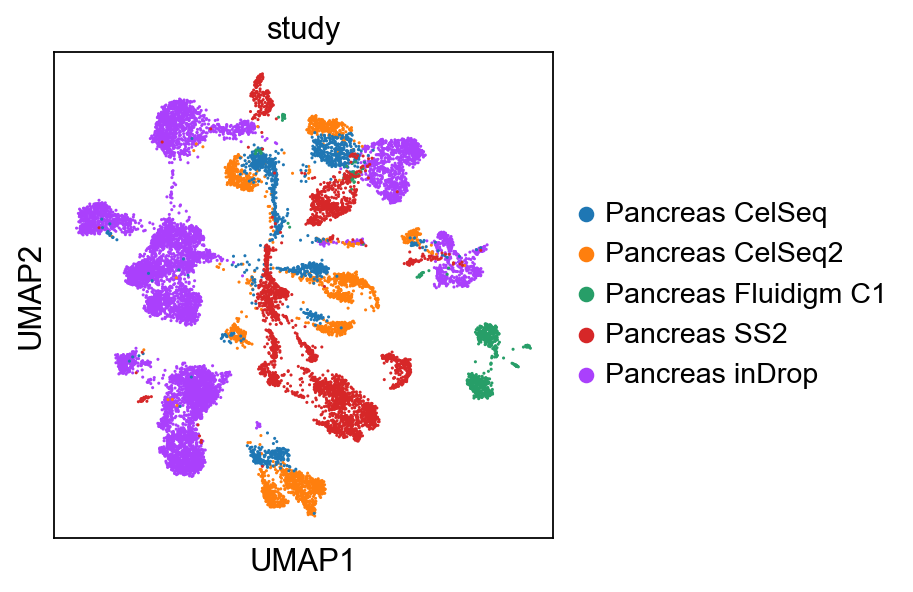

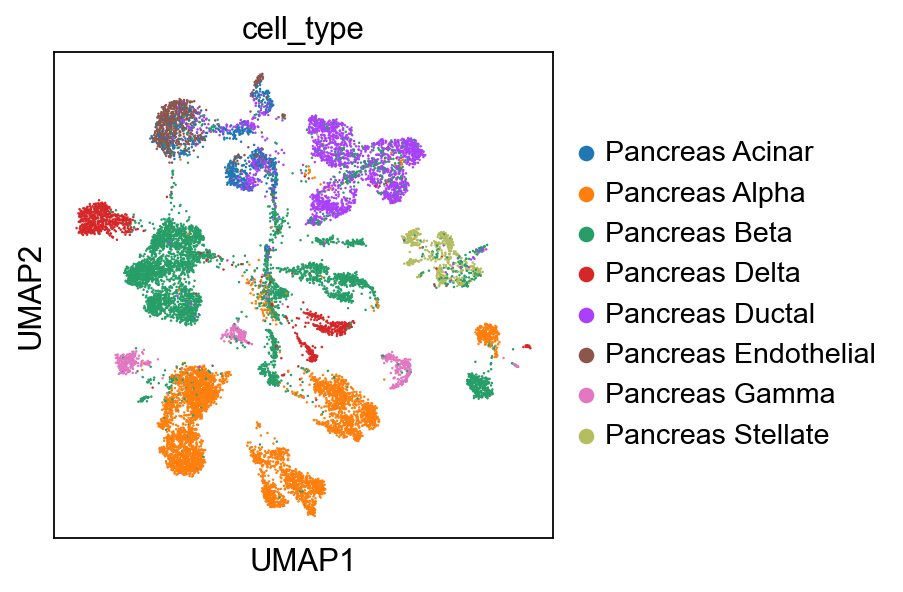

In [102]:
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)

In [281]:
data = torch.FloatTensor(adata.X)
enc_ct.fit(adata.obs["cell_type"])
enc_ct2.fit(adata.obs["study"])
labels = torch.IntTensor(
        enc_ct.transform(adata.obs["cell_type"]))
labels = F.one_hot(labels.long(), num_classes=enc_ct.classes_.size).float()
conds = torch.IntTensor(
        enc_ct2.transform(adata.obs["study"]))
conds = F.one_hot(conds.long(), num_classes=enc_ct2.classes_.size).float()
#dataset = ut.SynteticDataSet(data, labels)
dataset = ut.SynteticDataSetV2(dati=[data, labels, conds])
data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=128,
        shuffle=True,
        )

In [264]:
labels.shape
conds.shape
#adata.obs["study"]


In [304]:
reload (M15)
reload (Train)
model1500 = M15.AE_Type1500(
    nx = adata.n_vars,
    nh=1024,nhq=1024,nhp=1024,
    nz=64,
    zscale=1,
    numhidden=2,
    numhiddenq=2,
    numhiddenp=2,
    use_resnet=False,
    bn=True,
    reclosstype="mse",
    activation=nn.LeakyReLU(),
)
model1500.apply(init_weights)

model1501 = M15.VAE_AE_Type1501(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=32,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=4,
    dropout=0.25,
    use_resnet=False,
    reclosstype="mse",
    restrict_w="lv",
)
model1501.apply(init_weights)

model1501cc = M15.VAE_AE_Type1501CC(
    nx=adata.n_vars,
    nh=1024*2,
    nhp=1024*2,
    nhq=1024*2,
    nz=64,
    nw=32,
    numhidden=4,
    numhiddenp=4,
    numhiddenq=4,
    dropout=0.15,
    use_resnet=False,
    #reclosstype="mse",
    restrict_w=True,
    nc1=5,
    nclasses=8,
    eps=1e-7,
)
model1501cc.apply(init_weights)

model1503 = M15.VAE_GMM_Type1503(
    nx=adata.n_vars,
    nh=1024*2,
    nhp=1024*2,
    nhq=1024*2,
    nz=64,
    nw=32,
    numhidden=3,
    numhiddenp=3,
    numhiddenq=3,
    dropout=0.25,
    use_resnet=False,
    nclasses=labels.shape[1],
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.15,
    #restrict_w=False,
    #restrict_w="lv",
    #restrict_z="lv",
    #reclosstype="mse",
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    activation=nn.LeakyReLU(),
        )
model1503.apply(init_weights)

model1501cc.nclasses


True
True


8

In [305]:
#Train.basicTrainLoop(
#        model=model1500,
#        train_loader=data_loader,
#        test_loader=None,
#        num_epochs=21,
#        lrs=[1e-3, 1e-3, 1e-4, 1e-5],
#        wt=0,
#        report_interval=15,
#        )

#Train.basicTrainLoopCond(
#        #model=model1500,
#        model=model1501c,
#        train_loader=data_loader,
#        test_loader=None,
#        num_epochs=21,
#        lrs=[1e-3, 1e-3, 1e-4, 1e-5],
#        wt=0,
#        report_interval=15,
#        )

Train.trainSuperLoopCond(
    model1501cc,
    train_loader_labeled=data_loader,
        num_epochs=21,
        lrs=[1e-3, 1e-3, 1e-4, 1e-5],
        wt=0,
        report_interval=15,
)

epoch 0
labeled phase
rec: 4032.31005859375
loss_y: 2.7992501258850098
loss_z: 584.1870727539062
total_loss: 4619.29638671875

epoch 15
labeled phase
rec: 1375.8419189453125
loss_y: 0.36954933404922485
loss_z: 43.961238861083984
total_loss: 1420.172607421875

done training
epoch 0
labeled phase
rec: 1413.8740234375
loss_y: 0.38215088844299316
loss_z: 28.983177185058594
total_loss: 1443.2393798828125

epoch 15
labeled phase
rec: 1319.866455078125
loss_y: 0.41373971104621887
loss_z: 62.0003662109375
total_loss: 1382.280517578125

done training
epoch 0
labeled phase
rec: 1312.75341796875
loss_y: 0.7308914065361023
loss_z: 45.15986251831055
total_loss: 1358.6441650390625

epoch 15
labeled phase
rec: 1324.597900390625
loss_y: 0.2518729567527771
loss_z: 15.353286743164062
total_loss: 1340.2030029296875

done training
epoch 0
labeled phase
rec: 1319.871826171875
loss_y: 0.19028745591640472
loss_z: 16.175708770751953
total_loss: 1336.23779296875

epoch 15
labeled phase
rec: 1332.7939453125
los

In [311]:
labels.shape
conds.shape
data.shape
model1501cc.restrict_w
model1501cc.restrict_z

False

In [307]:
model1501cc.cpu()
model1501cc.eval()
#output = model1501c(data, cond1=conds)
output = model1501cc(data, cond1=conds, y=labels)
adata.obsm["z"] = output["z"].detach().numpy()
#adata.obsm["w"] = output["w"].detach().numpy()
del output

In [308]:
sc.pp.neighbors(adata, use_rep="z", n_neighbors=9,)
#sc.pp.neighbors(adata, use_rep="w", n_neighbors=9,)
sc.tl.umap(adata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


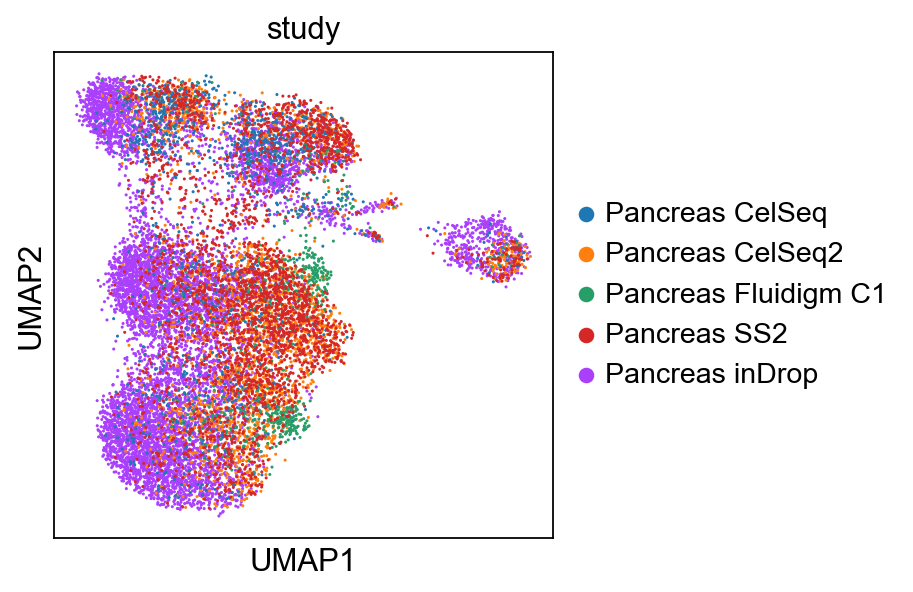

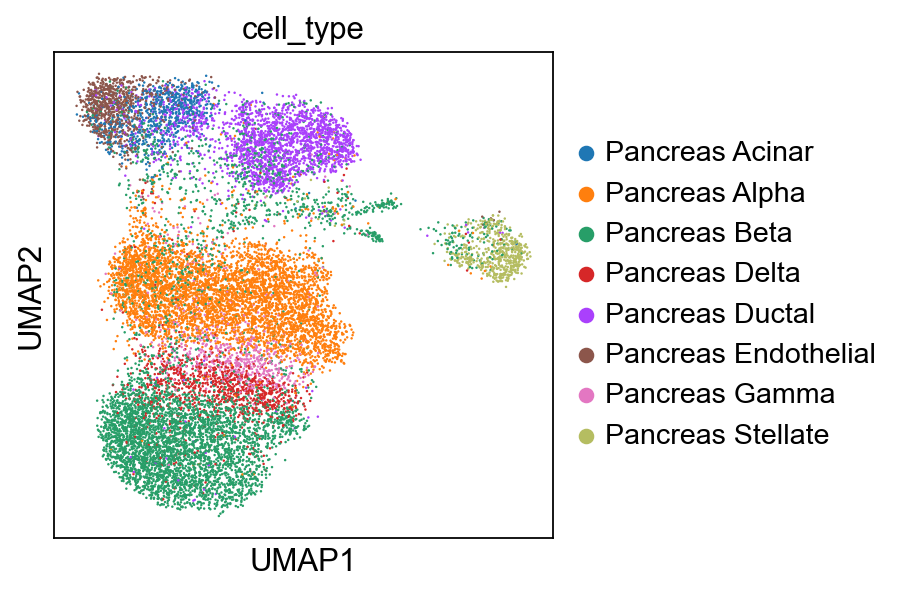

In [309]:
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)


In [312]:
reload(M15)
model1501cc2 = M15.VAE_AE_Type1501CC(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=32,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.25,
    use_resnet=False,
    reclosstype="mse",
    #restrict_z=True,
    nc1=5,
    nclasses=8,
    eps=1e-7,
)
model1501cc2.apply(init_weights)
Train.trainSuperLoopCond(
    model1501cc2,
    train_loader_labeled=data_loader,
        num_epochs=11,
        lrs=[1e-3, 1e-3, 1e-4],
        wt=0,
        report_interval=25,
)


True
epoch 0
labeled phase
rec: 6105.9443359375
loss_y: 2.674034595489502
loss_z: 273.200439453125
total_loss: 6381.818359375

done training
epoch 0
labeled phase
rec: 1893.40771484375
loss_y: 0.15026719868183136
loss_z: 71.14714050292969
total_loss: 1964.705078125

done training
epoch 0
labeled phase
rec: 1738.27197265625
loss_y: 0.1548002064228058
loss_z: 78.60220336914062
total_loss: 1817.0289306640625

done training


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


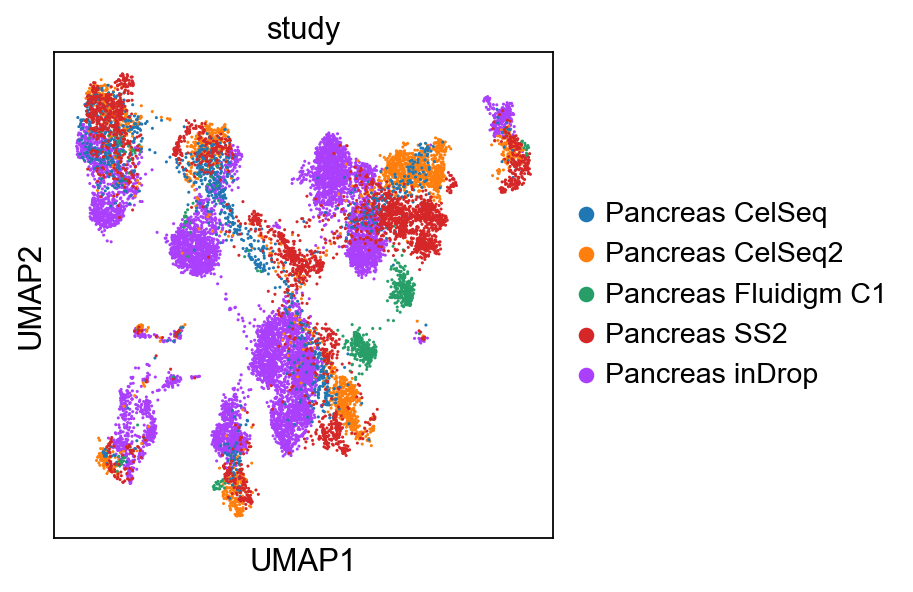

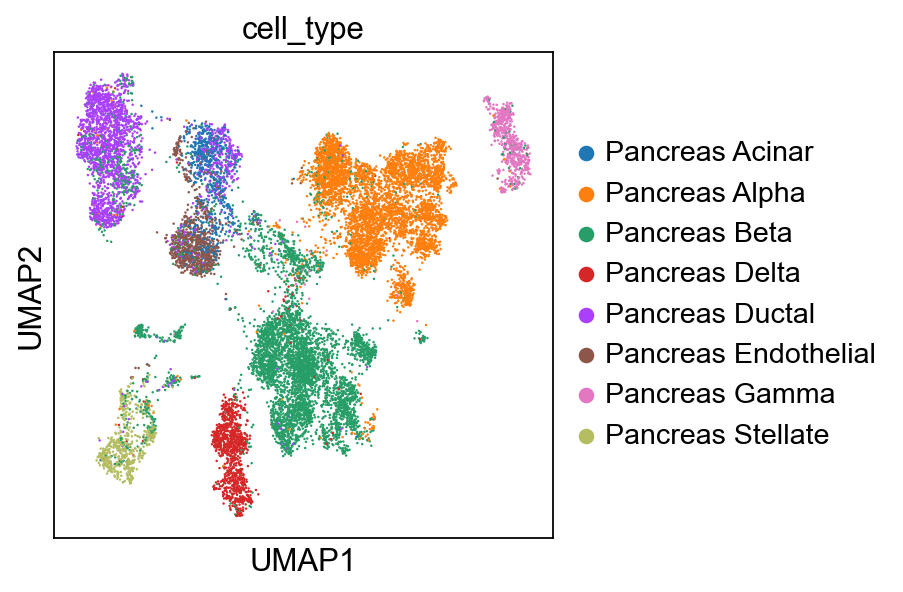

In [313]:
model1501cc2.cpu()
model1501cc2.eval()
#output = model1501c(data, cond1=conds)
output = model1501cc2(data, cond1=conds, y=labels)
adata.obsm["z"] = output["z"].detach().numpy()
#adata.obsm["w"] = output["w"].detach().numpy()
del output
sc.pp.neighbors(adata, use_rep="z",)
sc.tl.umap(adata,)
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)


In [315]:
reload(M15)
model1501cc3 = M15.VAE_AE_Type1501CC(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=32,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.25,
    use_resnet=False,
    reclosstype="mse",
    #restrict_z=True,
    nc1=5,
    nclasses=8,
    eps=1e-7,
    learned_prior=False,
)
model1501cc3.apply(init_weights)
Train.trainSuperLoopCond(
    model1501cc3,
    train_loader_labeled=data_loader,
        num_epochs=11,
        lrs=[1e-3, 1e-3, 1e-4],
        wt=0,
        report_interval=25,
)


True
epoch 0
labeled phase
rec: 5797.388671875
loss_y: 2.465914011001587
loss_z: 51.58529281616211
total_loss: 5851.43994140625

done training
epoch 0
labeled phase
rec: 1845.0908203125
loss_y: 0.2604295313358307
loss_z: 72.97478485107422
total_loss: 1918.325927734375

done training
epoch 0
labeled phase
rec: 1814.2149658203125
loss_y: 0.20927686989307404
loss_z: 85.53671264648438
total_loss: 1899.9609375

done training


In [322]:
model1501cc3.cpu()
model1501cc3.eval()
#output = model1501c(data, cond1=conds)
output = model1501cc3(data, cond1=conds, y=labels)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#adata.obsm["w"] = output["w"].detach().numpy()
del output
sc.pp.neighbors(adata, use_rep="z",)
sc.tl.umap(adata,)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


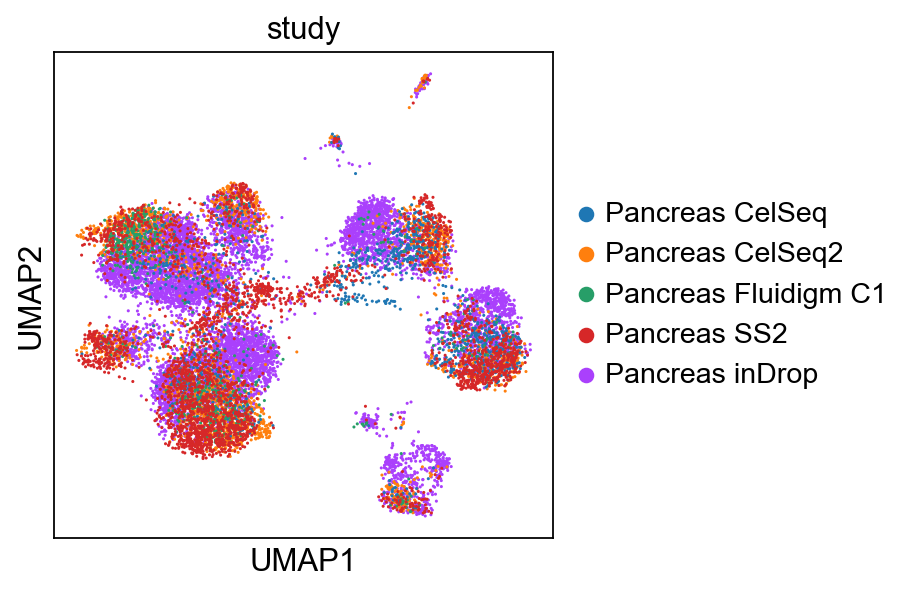

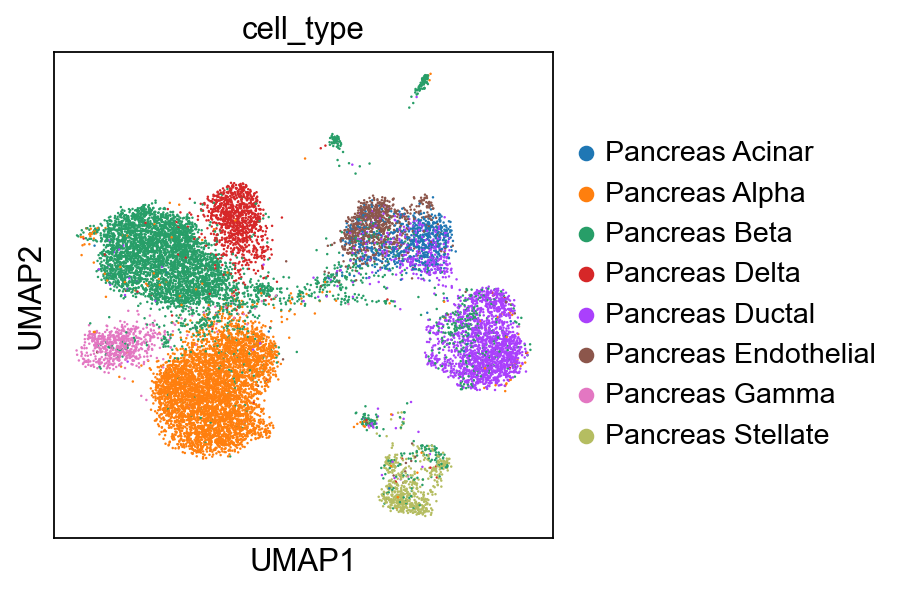

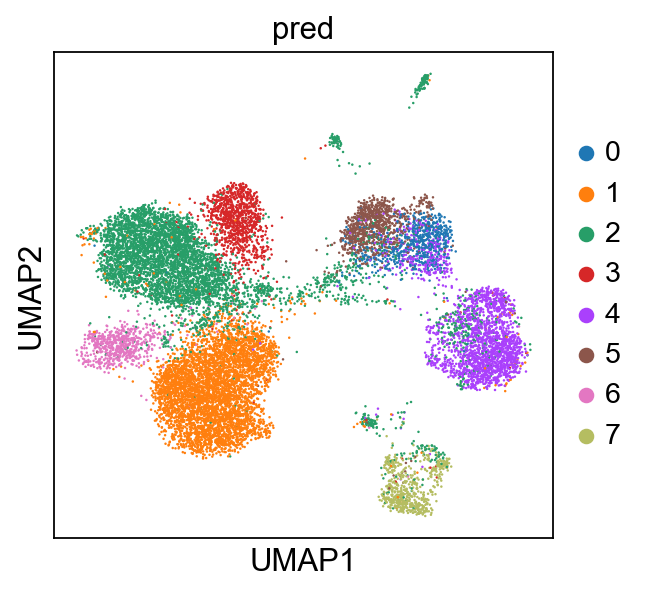

In [323]:
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)
sc.pl.umap(adata, color=['pred'], size=5, wspace=5)


In [137]:
Train.trainSemiSuperLoop(
   model1503,
   train_loader_labeled=data_loader,
   train_loader_unlabeled=data_loader,
   #train_loader_labeled=labeled_loader,
   #train_loader_unlabeled=unlabeled_loader,
   test_loader=data_loader,
   #test_loader=test_loader,
   num_epochs=35,
   #lrs=[1e-5,1e-4,1e-3,1e-4,1e-5],
   lrs=[1e-3,1e-3,1e-4,1e-5],
   wt=0,
   do_unlabeled=False,
   #do_unlabeled=True,
   do_validation=False,
   #do_validation=True,
   report_interval=19,
   do_plot=False,
   test_accuracy=True,
)


epoch 0
labeled phase
rec: 4026.1318359375
loss_z: 100.71955871582031
loss_w: 22.270057678222656
loss_cluster: -0.333001047372818
loss_y: 2.571951389312744
total_loss: 4151.693359375
num_clusters: 7

[ 0.  1.  2.  3.  4.  5. -1.  7.] 
 0.5984936692205256 
 [ 0.57142857  0.83653846  0.98039216  1.          0.52459016  1.
 -1.          0.875     ]
0.796078431372549 

epoch 19
labeled phase
rec: 1409.853515625
loss_z: 11.75493049621582
loss_w: 2.584446668624878
loss_cluster: -0.9955762624740601
loss_y: 0.020640812814235687
total_loss: 1424.2135009765625
num_clusters: 8

[0. 1. 2. 3. 4. 5. 6. 7.] 
 0.9886363636363636 
 [1.         1.         1.         1.         1.         0.90909091
 1.         1.        ]
0.99609375 

done training
epoch 0
labeled phase
rec: 1334.096923828125
loss_z: 10.905887603759766
loss_w: 2.2490363121032715
loss_cluster: -0.9960054159164429
loss_y: 0.008977147750556469
total_loss: 1347.2608642578125
num_clusters: 8

[0. 1. 2. 3. 4. 5. 6. 7.] 
 1.0 
 [1. 1. 1. 1. 1.

In [138]:
model1503.cpu()
model1503.eval()
output = model1503(data)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
del output

In [139]:
sc.pp.neighbors(adata, use_rep="z", n_neighbors=9,)
sc.tl.umap(adata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


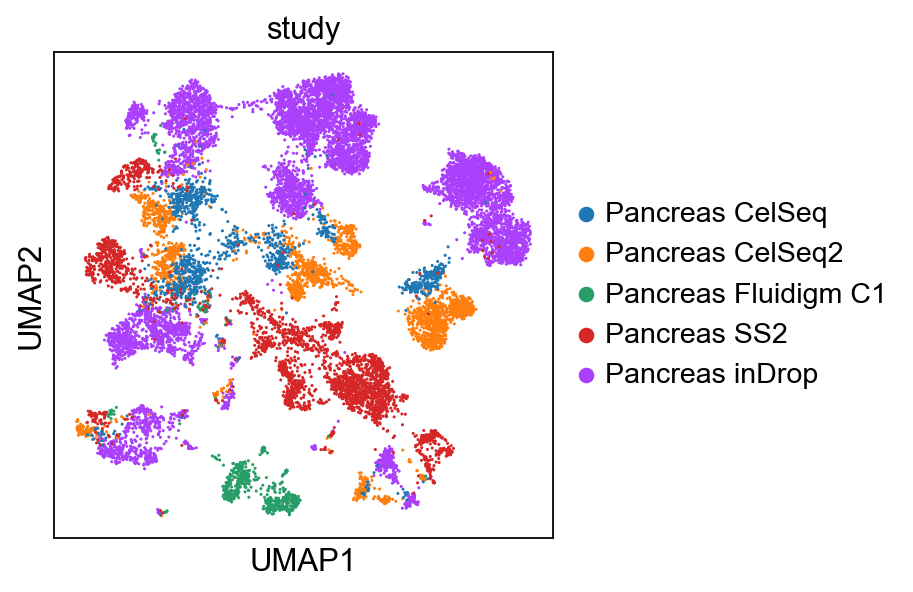

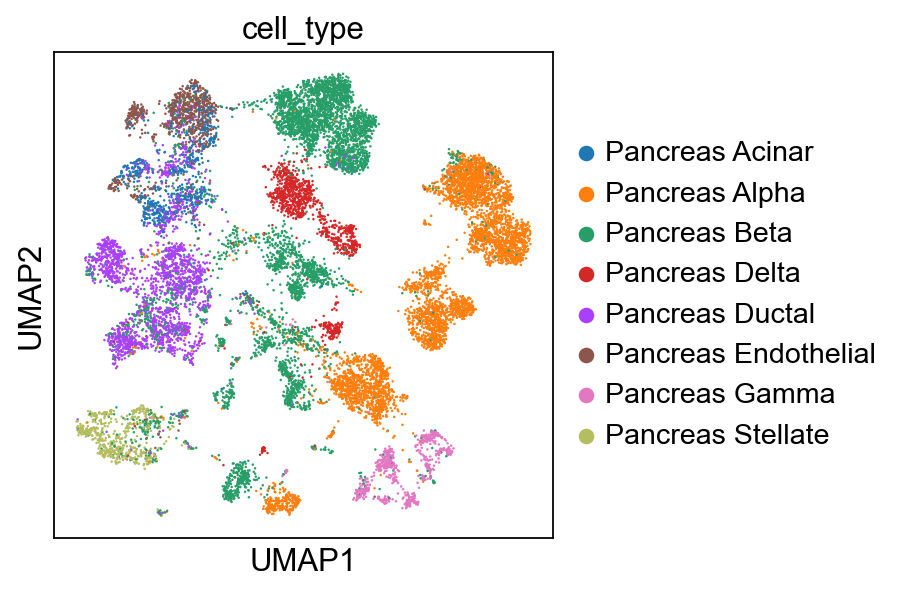

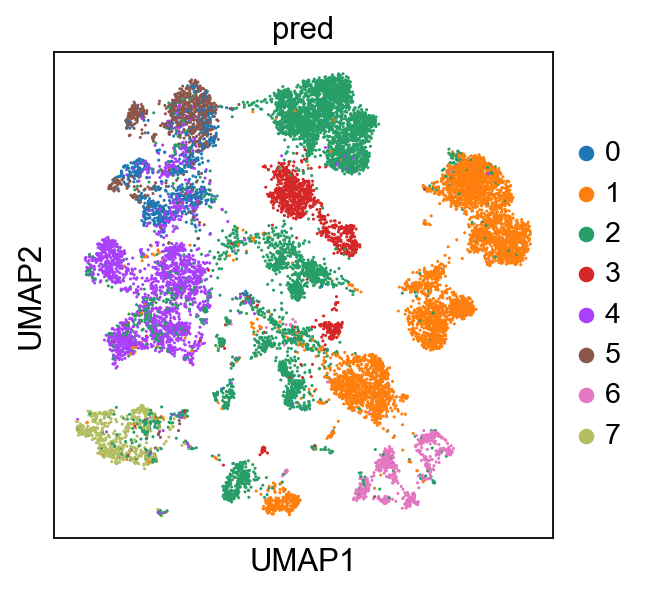

In [140]:
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)
sc.pl.umap(adata, color=['pred'], wspace=0.35 )

In [142]:
output = model1503(data)

In [146]:
(data - output["rec"]).abs().sum(1)

tensor([694.4115, 674.1740, 668.8542,  ..., 712.6212, 651.9391, 652.2938],
       grad_fn=<SumBackward1>)

In [147]:
data.abs().sum(1)

tensor([1038.0992, 1135.2307,  850.8329,  ..., 1297.7527, 1095.2931,
        1242.2714])

In [156]:
data[100].shape
output['rec'][100].shape
output['rec'][100] - data[100]
output['rec'][100].mean()
data[100].mean()
#adata.raw.X[100]

tensor(0.7715)

In [179]:
bdata = sc.read("./data/pancreas.h5ad")
bdata.X = bdata.raw.X
sc.pp.filter_cells(bdata, min_genes=50)
sc.pp.filter_genes(bdata, min_cells=3)

filtered out 158 cells that have less than 50 genes expressed
filtered out 5 genes that are detected in less than 3 cells


In [181]:
bdata.obs["cell_type"].shape
bdata.obs
bdata
bdata.X.sum(1)

array([ 8874.,  9787.,  8361., ..., 66815., 23327., 17558.], dtype=float32)

In [187]:
sc.pp.normalize_total(bdata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [189]:
bdata.X.sum(1)
bdata

AnnData object with n_obs × n_vars = 15523 × 995
    obs: 'batch', 'study', 'cell_type', 'size_factors', 'n_genes'
    var: 'n_cells'

In [191]:
sc.pp.log1p(bdata)
bdata.X.sum(1)

array([368.96796, 402.13028, 285.3626 , ..., 412.4466 , 509.31778,
       546.19946], dtype=float32)

In [194]:
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [196]:
bdata = bdata[:, bdata.var.highly_variable]
bdata

View of AnnData object with n_obs × n_vars = 15523 × 242
    obs: 'batch', 'study', 'cell_type', 'size_factors', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [197]:
data = torch.FloatTensor(bdata.X)
enc_ct.fit(bdata.obs["cell_type"])
labels = torch.IntTensor(
        enc_ct.transform(bdata.obs["cell_type"]))
labels = F.one_hot(labels.long(), num_classes=enc_ct.classes_.size).float()
dataset = ut.SynteticDataSet(data, labels)
data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=256,
        shuffle=True,
        )


In [199]:
model1503 = M15.VAE_GMM_Type1503(
    nx=bdata.n_vars,
    nh=1024*2,
    nhp=1024*2,
    nhq=1024*2,
    nz=64,
    nw=32,
    numhidden=3,
    numhiddenp=3,
    numhiddenq=3,
    dropout=0.25,
    use_resnet=False,
    nclasses=labels.shape[1],
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.15,
    #restrict_w=False,
    #restrict_w="lv",
    #restrict_z="lv",
    #reclosstype="mse",
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    activation=nn.LeakyReLU(),
        )
model1503.apply(init_weights)
model1503.nclasses


8

In [200]:
Train.trainSemiSuperLoop(
   model1503,
   train_loader_labeled=data_loader,
   train_loader_unlabeled=data_loader,
   #train_loader_labeled=labeled_loader,
   #train_loader_unlabeled=unlabeled_loader,
   test_loader=data_loader,
   #test_loader=test_loader,
   num_epochs=35,
   #lrs=[1e-5,1e-4,1e-3,1e-4,1e-5],
   lrs=[1e-3,1e-3,1e-4,1e-5],
   wt=0,
   do_unlabeled=False,
   #do_unlabeled=True,
   do_validation=False,
   #do_validation=True,
   report_interval=19,
   do_plot=False,
   test_accuracy=True,
)


epoch 0
labeled phase
rec: 406.84075927734375
loss_z: 165.85789489746094
loss_w: 29.103008270263672
loss_cluster: -0.37939324975013733
loss_y: 2.5756239891052246
total_loss: 604.3773193359375
num_clusters: 3

[-1. -1.  2. -1.  1. -1. -1. -1.] 
 -0.5866141732283465 
 [-1.         -1.          1.         -1.          0.30708661 -1.
 -1.         -1.        ]
0.344 

epoch 19
labeled phase
rec: 139.83111572265625
loss_z: 5.794589996337891
loss_w: 0.7213635444641113
loss_cluster: -0.9000248908996582
loss_y: 0.24530386924743652
total_loss: 146.5923614501953
num_clusters: 8

[0. 1. 2. 2. 4. 5. 6. 7.] 
 0.7850646441372249 
 [0.6875     0.93055556 0.98571429 0.38709677 0.93548387 0.6875
 0.66666667 1.        ]
0.8359375 

done training
epoch 0
labeled phase
rec: 144.21539306640625
loss_z: 6.5858564376831055
loss_w: 0.5997726917266846
loss_cluster: -0.9413058757781982
loss_y: 0.11655580252408981
total_loss: 151.51759338378906
num_clusters: 8

[0. 1. 2. 3. 4. 5. 6. 7.] 
 0.8556630546955624 
 [0.6

In [201]:
model1503.cpu()
model1503.eval()
output = model1503(data)
bdata.obsm["z"] = output["z"].detach().numpy()
bdata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
del output


In [202]:
sc.pp.neighbors(bdata, use_rep="z", n_neighbors=9,)
sc.tl.umap(bdata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


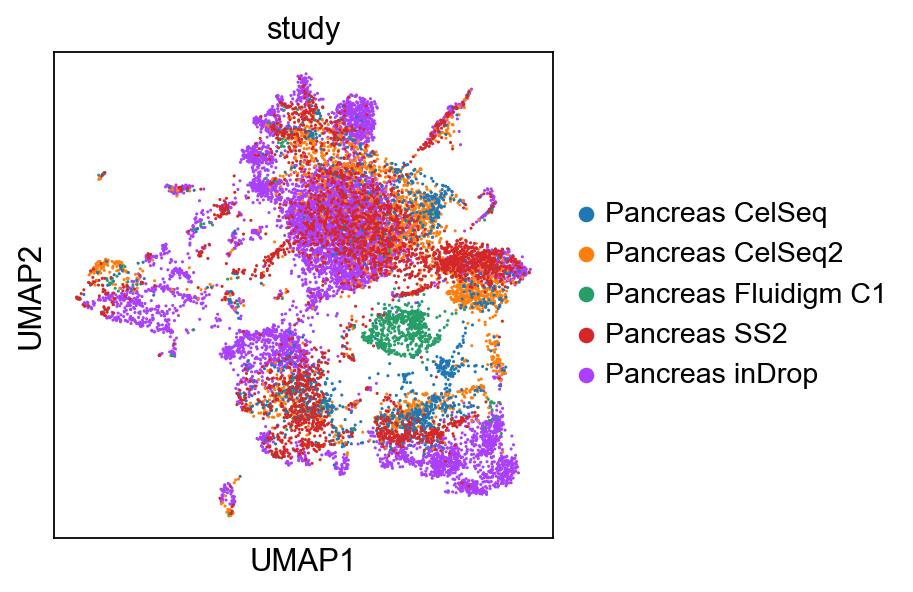

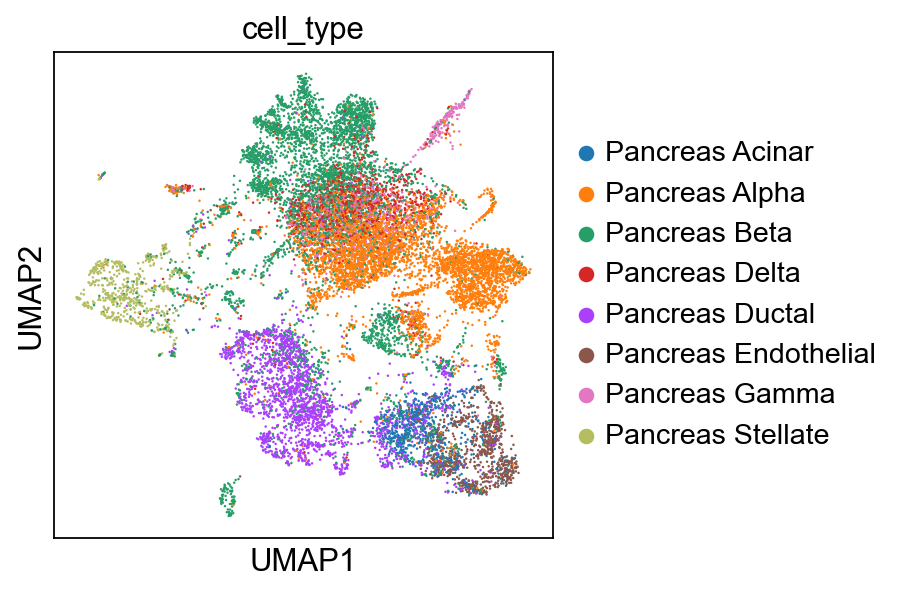

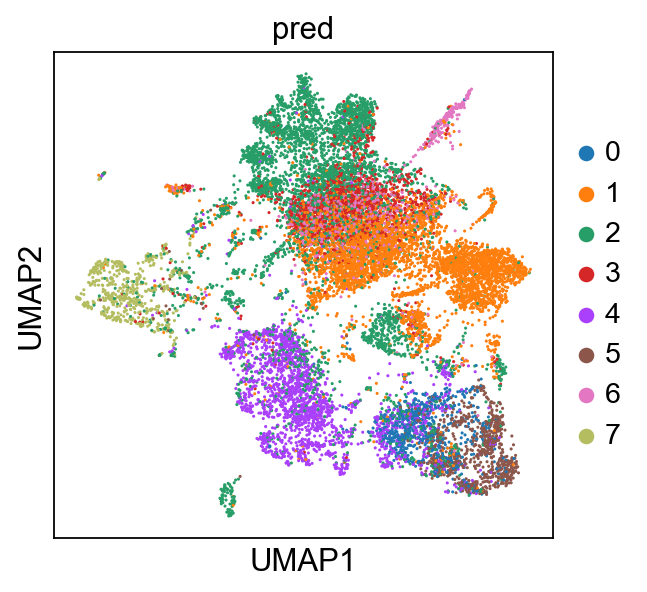

In [204]:
sc.pl.umap(bdata, color=['study', ], wspace=0.35)
sc.pl.umap(bdata, color=['cell_type'], size=5, wspace=5)
sc.pl.umap(bdata, color=['pred'], wspace=0.35 )


In [325]:
reload (M15)
reload (Train)
model1503c = M15.VAE_GMM_Type1503C(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=32,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.20,
    use_resnet=False,
    nclasses=labels.shape[1],
    nc1 = 5,
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.15,
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    reclosstype="mse",
    learned_prior = False,
    activation=nn.LeakyReLU(),
        )
model1503c.apply(init_weights)


True
True


VAE_GMM_Type1503C(
  (Px): Sequential(
    (linear1): Linear(in_features=69, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=1000, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True

In [328]:
#model1503c(input[0], input[2], input[1])
adata.n_obs


15681

In [332]:
data = torch.FloatTensor(adata.X)
enc_ct.fit(adata.obs["cell_type"])
enc_ct2.fit(adata.obs["study"])
labels = torch.IntTensor(
        enc_ct.transform(adata.obs["cell_type"]))
labels = F.one_hot(labels.long(), num_classes=enc_ct.classes_.size).float()
conds = torch.IntTensor(
        enc_ct2.transform(adata.obs["study"]))
conds = F.one_hot(conds.long(), num_classes=enc_ct2.classes_.size).float()
#dataset = ut.SynteticDataSet(data, labels)
#dataset = ut.SynteticDataSetV2(dati=[data, labels, conds])
subset = ut.randomSubset(s=len(labels), r=0.11)
data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSetV2(dati=[data, labels, conds]),
        batch_size=128,
        shuffle=True,
        )

labeled_data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSetV2(
            dati=[data[subset], labels[subset], conds[subset]]),
        batch_size=128,
        shuffle=True,
        )
unlabeled_data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSetV2(
            dati=[data[subset == False], labels[subset == False], conds[subset == False]]),
        batch_size=128,
        shuffle=True,
        )

In [333]:
Train.trainSemiSuperLoopCond(
    model1503c,
    labeled_data_loader,
    unlabeled_data_loader,
    labeled_data_loader,
    num_epochs=50,
    lrs = [1e-3,1e-3,1e-4,1e-5],
    device="cuda",
    wt=0,
    do_unlabeled=True,
    do_validation=False,
    report_interval=25,
    do_plot=False,
    test_accuracy=False,
)

epoch 0
labeled phase
rec: 6002.37890625
loss_z: 97.12205505371094
loss_w: 23.644685745239258
loss_cluster: -0.33326080441474915
loss_y: 2.1287901401519775
total_loss: 6125.2744140625
num_clusters: 5

unlabeled phase
rec: 2835.15234375
loss_z: 68.82486724853516
loss_w: 10.605484008789062
loss_cluster: -0.8749043345451355
loss_y: 0.5119449496269226
total_loss: 2915.0947265625
num_clusters: 6

epoch 25
labeled phase
rec: 1912.52197265625
loss_z: 31.283233642578125
loss_w: 9.218122482299805
loss_cluster: -0.9814903736114502
loss_y: 0.31632381677627563
total_loss: 1953.339599609375
num_clusters: 8

unlabeled phase
rec: 1923.1728515625
loss_z: 31.250457763671875
loss_w: 8.9482421875
loss_cluster: -0.9760610461235046
loss_y: 0.24739781022071838
total_loss: 1963.6190185546875
num_clusters: 8

done training
epoch 0
labeled phase
rec: 1721.083740234375
loss_z: 37.370548248291016
loss_w: 8.402360916137695
loss_cluster: -0.9857401847839355
loss_y: 0.47902756929397583
total_loss: 1767.335693359375

In [353]:
model1503c.cpu()
model1503c.eval()
#output = model1501c(data, cond1=conds)
output = model1503c(data, cond1=conds, y=labels)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#adata.obsm["w"] = output["w"].detach().numpy()
del output


In [354]:
sc.pp.neighbors(adata, use_rep="z",)
sc.tl.umap(adata,)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


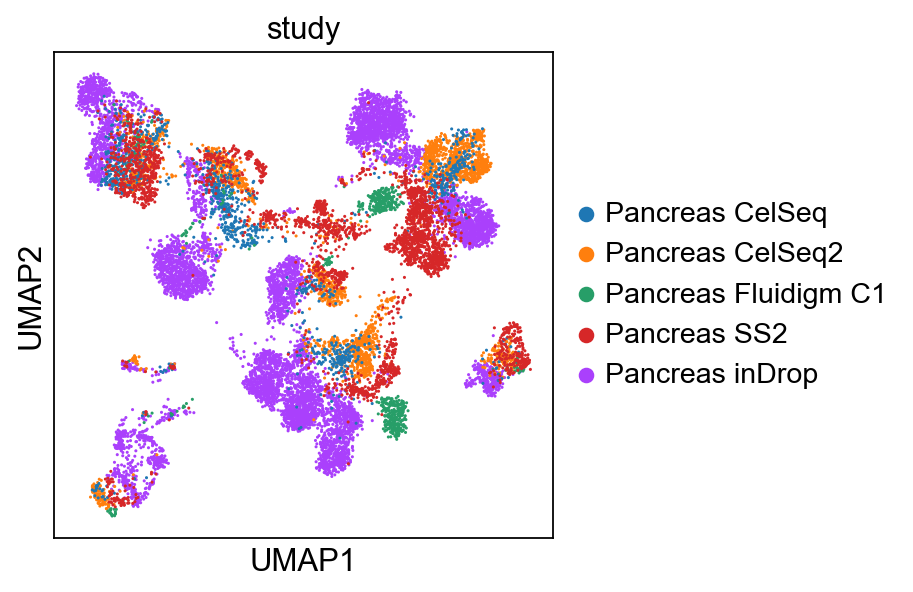

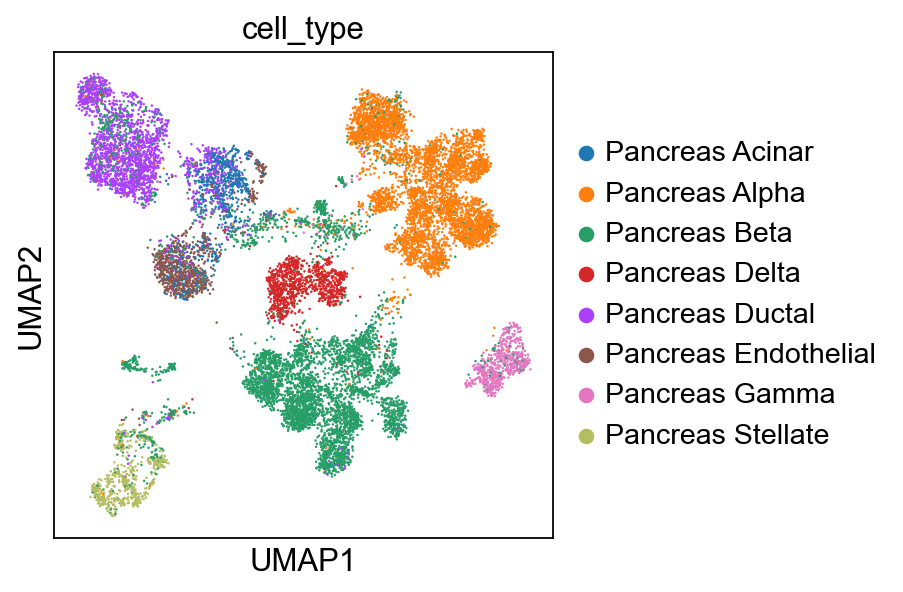

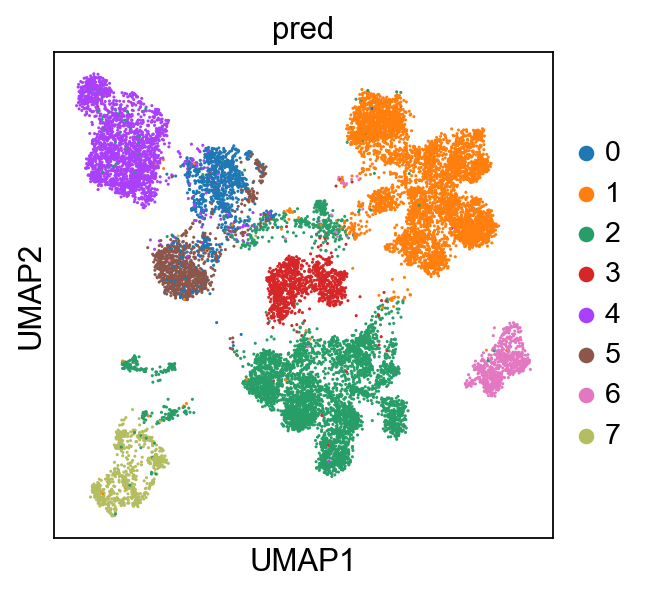

In [355]:
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)
sc.pl.umap(adata, color=['pred'], wspace=0.35 )


In [337]:
reload (M15)
reload (Train)
model1503c2 = M15.VAE_GMM_Type1503C(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=32,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.20,
    use_resnet=False,
    nclasses=labels.shape[1],
    nc1 = 5,
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.15,
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    #reclosstype="mse",
    #learned_prior = False,
    learned_prior = True,
    activation=nn.LeakyReLU(),
        )
model1503c2.apply(init_weights)


True
True


VAE_GMM_Type1503C(
  (Px): Sequential(
    (linear1): Linear(in_features=69, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=1000, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True

In [338]:
Train.trainSemiSuperLoopCond(
    model1503c2,
    labeled_data_loader,
    unlabeled_data_loader,
    labeled_data_loader,
    num_epochs=80,
    lrs = [1e-3,1e-3,1e-4,1e-5],
    device="cuda",
    wt=0,
    do_unlabeled=True,
    do_validation=False,
    report_interval=65,
    do_plot=False,
    test_accuracy=True,
)


epoch 0
labeled phase
rec: 4066.87255859375
loss_z: 88.14302062988281
loss_w: 147.3489990234375
loss_cluster: -0.32054001092910767
loss_y: 2.498730182647705
total_loss: 4304.86328125
num_clusters: 5

[1. 1. 1. 1. 1. 1. 2. 1.] 
 0.5858405483405482 
 [1.         0.66666667 0.28571429 0.66666667 0.3        0.55555556
 0.66666667 0.54545455]
0.390625 

unlabeled phase
rec: 2400.77001953125
loss_z: 48.30632781982422
loss_w: 18.42578887939453
loss_cluster: -0.8009433746337891
loss_y: 0.32479336857795715
total_loss: 2467.826904296875
num_clusters: 7

epoch 65
labeled phase
rec: 1310.864990234375
loss_z: 9.927576065063477
loss_w: 5.292037010192871
loss_cluster: -0.982818603515625
loss_y: 0.15635773539543152
total_loss: 1326.240966796875
num_clusters: 8

[0. 1. 2. 3. 4. 5. 6. 7.] 
 0.9260416666666667 
 [0.6        1.         1.         1.         0.93333333 0.875
 1.         1.        ]
0.953125 

unlabeled phase
rec: 1384.524169921875
loss_z: 12.760225296020508
loss_w: 5.222116470336914
loss_c

In [347]:
model1503c2.cpu()
model1503c2.eval()
#output = model1501c(data, cond1=conds)
output = model1503c2(data, cond1=conds, y=labels)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#adata.obsm["w"] = output["w"].detach().numpy()
del output


In [348]:
sc.pp.neighbors(adata, use_rep="z",)
sc.tl.umap(adata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


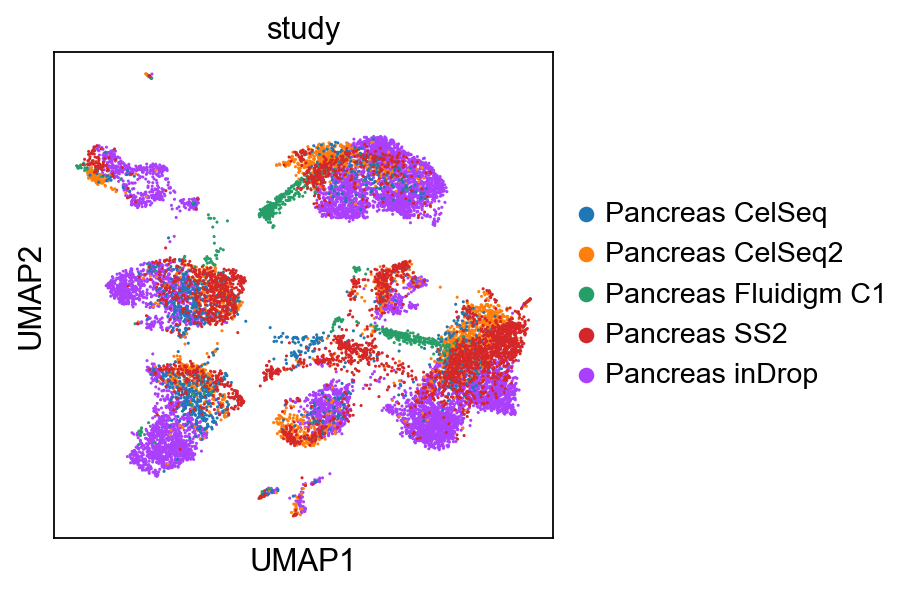

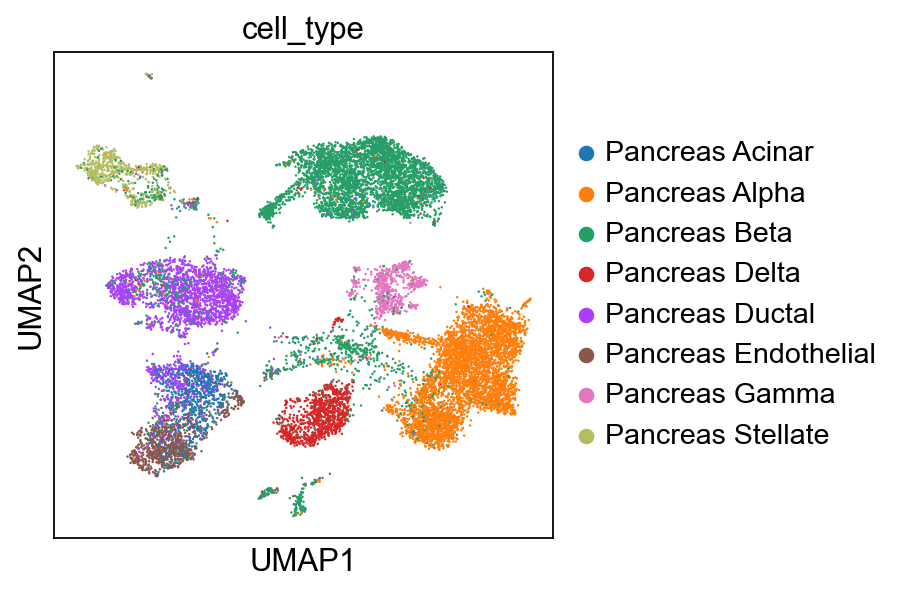

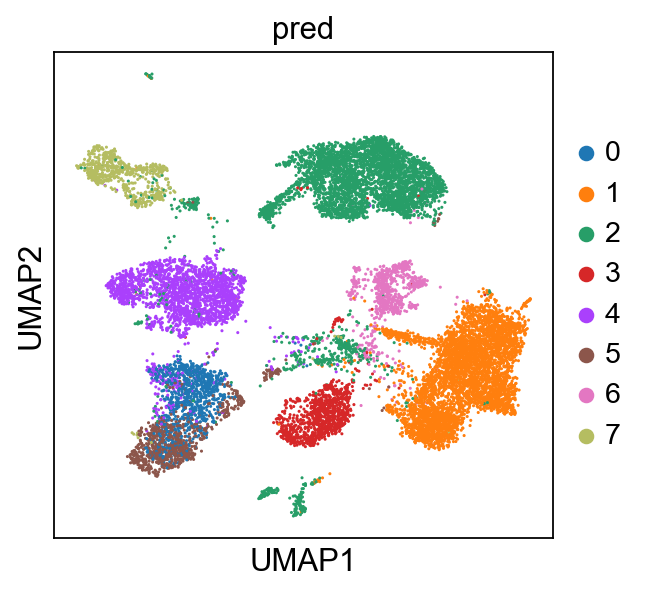

In [349]:
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)
sc.pl.umap(adata, color=['pred'], wspace=0.35 )

In [356]:
reload (M15)
reload (Train)
model1503c3 = M15.VAE_GMM_Type1503C(
    nx=adata.n_vars,
    nh=1024,
    nhp=1024,
    nhq=1024,
    nz=64,
    nw=32,
    numhidden=2,
    numhiddenp=2,
    numhiddenq=2,
    dropout=0.20,
    use_resnet=False,
    nclasses=labels.shape[1]*3,
    nc1 = 5,
    yscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.15,
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    #reclosstype="mse",
    #learned_prior = False,
    learned_prior = True,
    activation=nn.LeakyReLU(),
        )
model1503c3.apply(init_weights)


True
True


VAE_GMM_Type1503C(
  (Px): Sequential(
    (linear1): Linear(in_features=69, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True)
    (dropout2): Dropout(p=0.2, inplace=False)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation2): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=1024, out_features=1000, bias=True)
  )
  (Pz): Sequential(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=1024, out_features=1024, bias=True

In [357]:
Train.basicTrainLoopCond(
    model1503c3,
    unlabeled_data_loader,
    labeled_data_loader,
    num_epochs=50,
    lrs = [1e-3, 1e-4, 1e-5],
    device="cuda",
    wt=0,
    report_interval=28,
    do_plot=False,
    test_accuracy=True,
)
    

epoch's lr =  0.001
epoch 0
training phase
rec: 4003.93701171875
loss_z: 59.98136901855469
loss_w: 229.8785858154297
loss_cluster: -0.19334694743156433
loss_y: 0.13803750276565552
total_loss: 4293.93505859375
num_clusters: 1

[ 1. -1.  4. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  7.  2.  1.  1. -1.
 -1. -1. -1. -1. -1. -1.] 
 -0.5549068986568987 
 [ 0.42857143 -1.          0.38461538 -1.         -1.         -1.
  0.5        -1.         -1.         -1.         -1.         -1.
 -1.          1.          0.57142857  0.29761905  0.5        -1.
 -1.         -1.         -1.         -1.         -1.         -1.        ]
0.5765765765765766 

epoch 28
training phase
rec: 1314.909912109375
loss_z: 9.57734489440918
loss_w: 4.357748031616211
loss_cluster: -0.9899328947067261
loss_y: 1.424353837966919
total_loss: 1330.2694091796875
num_clusters: 7

[ 1. -1.  4. -1. -1. -1. -1. -1. -1. -1. -1. -1.  2.  6. -1.  5. -1. -1.
 -1. -1. -1.  2. -1.  3.] 
 -0.47652674123262356 
 [ 0.97435897 -1.          0.571

In [359]:
model1503c3.cpu()
model1503c3.eval()
#output = model1501c(data, cond1=conds)
output = model1503c3(data, cond1=conds, y=None)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#adata.obsm["w"] = output["w"].detach().numpy()
del output


In [360]:
sc.pp.neighbors(adata, use_rep="z",)
sc.tl.umap(adata,)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


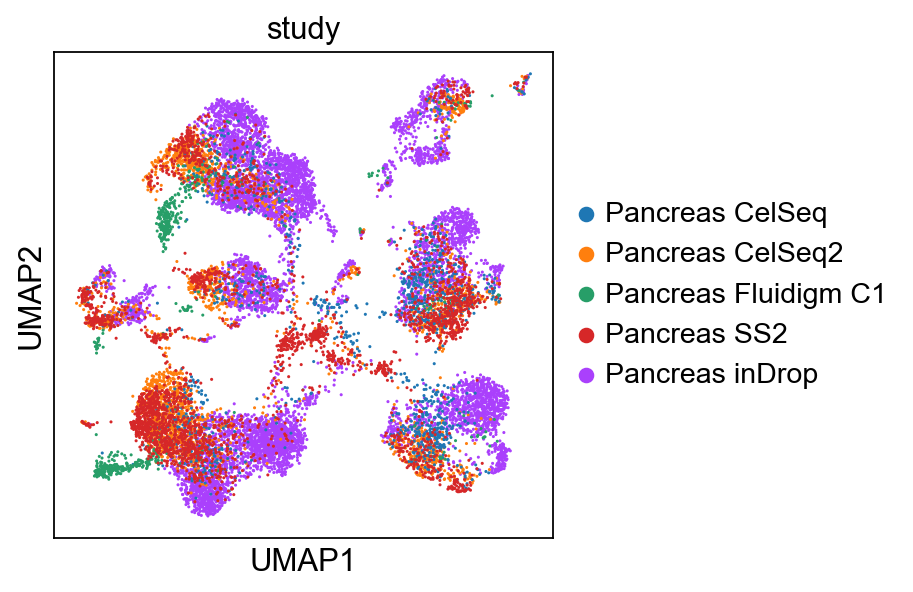

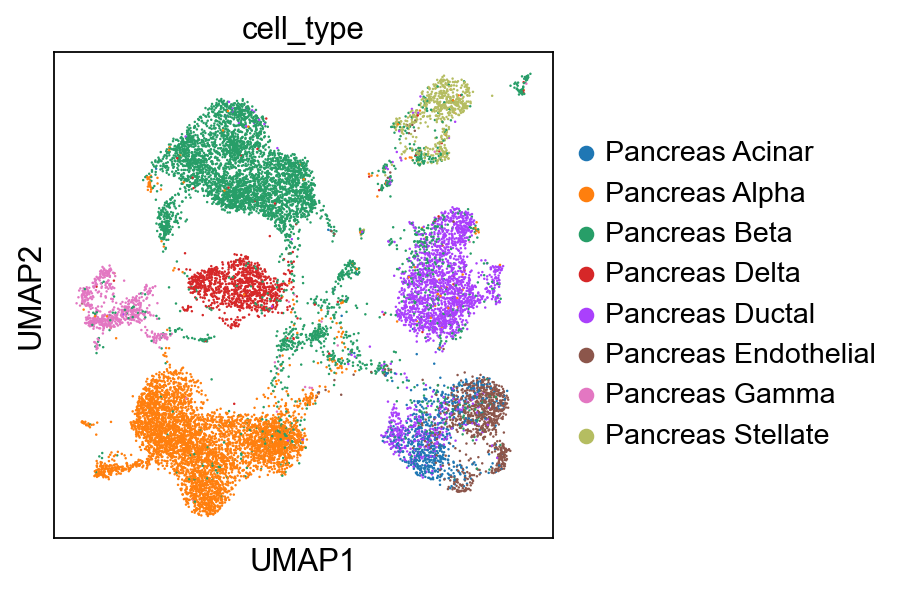

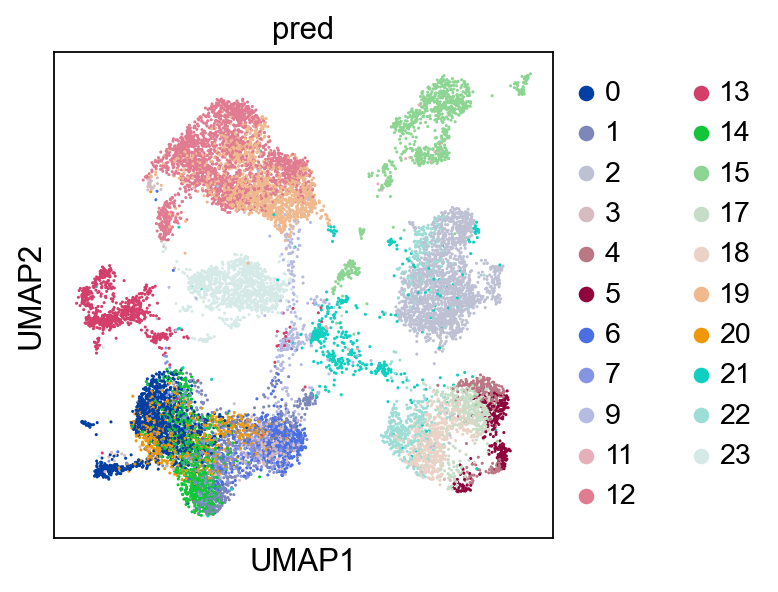

In [361]:
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)
sc.pl.umap(adata, color=['pred'], wspace=0.35 )


In [372]:
############# Dirichlet Models
reload (M15)
reload (Train)
model1502c = M15.VAE_Dirichlet_GMM_Type1502C(
    nx=adata.n_vars,
    nh=1024*2,
    nhp=1024*2,
    nhq=1024*2,
    nz=64,
    nw=32,
    numhidden=3,
    numhiddenp=3,
    numhiddenq=3,
    dropout=0.25,
    use_resnet=False,
    nclasses=labels.shape[1] * 4,
    nc1 = 5,
    yscale=1e0,
    dscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.15,
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    concentration=1e0,
    #reclosstype="mse",
    learned_prior = True,
    activation=nn.LeakyReLU(),
        )
model1502c.apply(init_weights)
model1502c.nclasses

True
True


32

In [373]:
Train.basicTrainLoopCond(
    model1502c,
    unlabeled_data_loader,
    labeled_data_loader,
    num_epochs=20,
    lrs = [1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
    device="cuda",
    wt=0,
    report_interval=28,
    do_plot=False,
    test_accuracy=True,
)
    


epoch's lr =  1e-05
epoch 0
training phase
rec: 4083.24560546875
loss_z: 81.60234069824219
loss_w: 146.2259979248047
loss_cluster: -0.1470065414905548
loss_d: 26.845458984375
loss_y_alt: 1.6434205770492554
loss_y_alt2: 0
total_loss: 4339.5634765625
num_clusters: 0

[ 1.  1. -1.  7.  1.  1. -1. -1. -1.  1.  1. -1.  5. -1.  0.  3. -1.  5.
  2.  1.  1. -1. -1. -1. -1. -1.  2.  1.  2.  1.  2. -1.] 
 -0.029800798160173163 
 [ 0.27083333  1.         -1.          1.          0.6         0.42857143
 -1.         -1.         -1.          1.          0.5        -1.
  0.4        -1.          0.5         0.5        -1.          1.
  0.46666667  0.66666667  0.5        -1.         -1.         -1.
 -1.         -1.          0.6         0.25        1.          1.
  0.36363636 -1.        ]
0.591304347826087 

epoch's lr =  0.0001
epoch 0
training phase
rec: 2074.032958984375
loss_z: 24.998905181884766
loss_w: 5.778390884399414
loss_cluster: -0.88865065574646
loss_d: 3.575490951538086
loss_y_alt: 3.050113

In [374]:
model1502c.cpu()
model1502c.eval()
#output = model1501c(data, cond1=conds)
output = model1502c(data, cond1=conds, y=None)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#adata.obsm["w"] = output["w"].detach().numpy()
del output


In [375]:
sc.pp.neighbors(adata, use_rep="z",)
sc.tl.umap(adata,)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


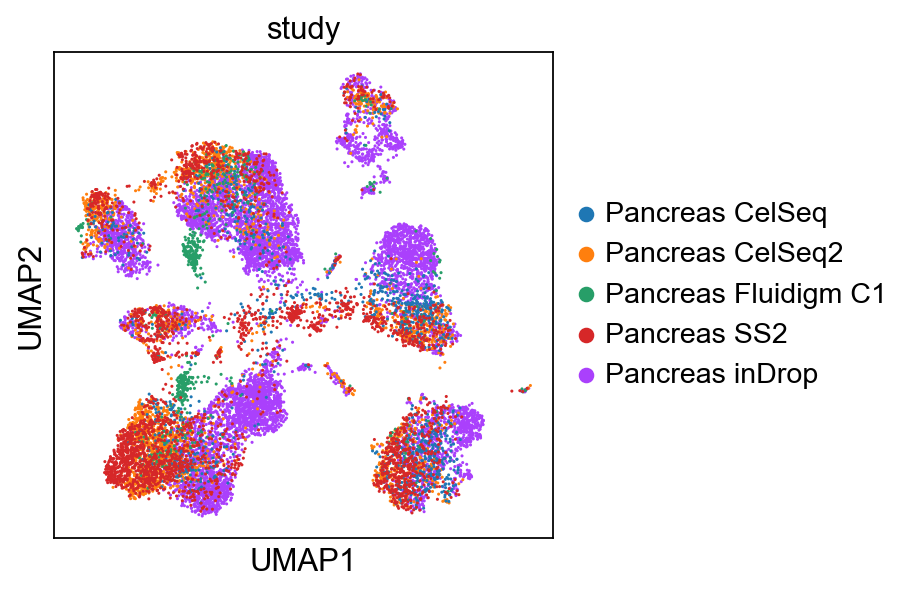

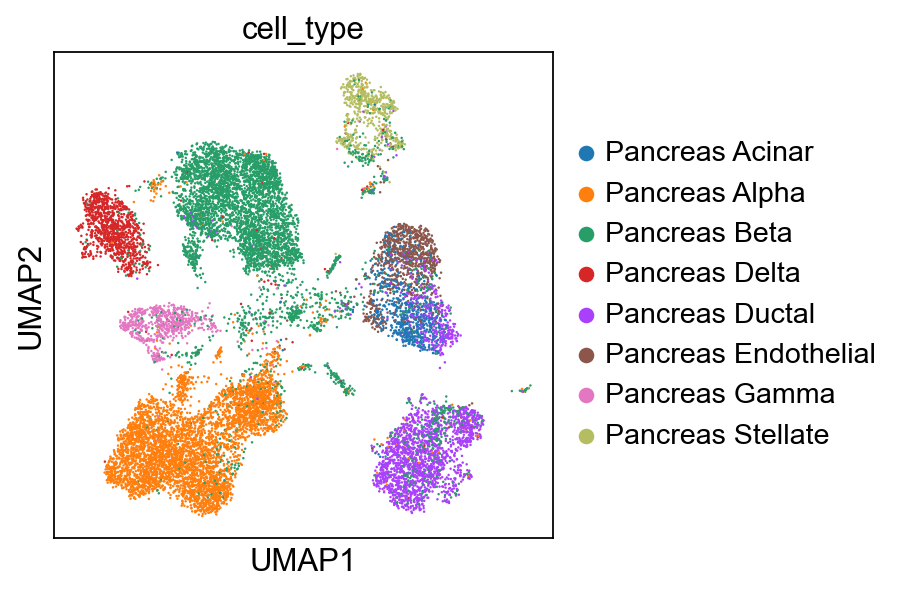

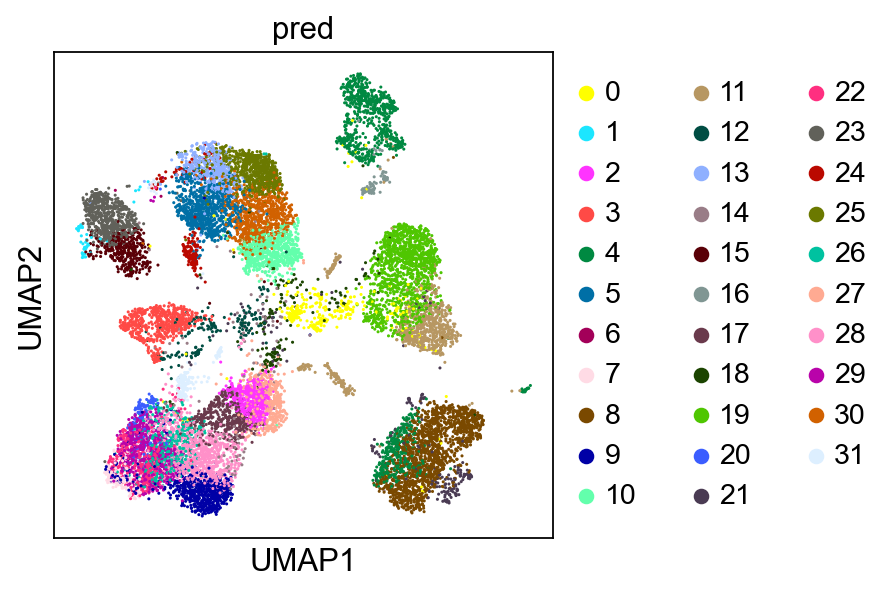

In [376]:
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)
sc.pl.umap(adata, color=['pred'], wspace=0.35 )


In [377]:
reload (M15)
reload (Train)
model1502c2 = M15.VAE_Dirichlet_GMM_Type1502C(
    nx=adata.n_vars,
    nh=1024*2,
    nhp=1024*2,
    nhq=1024*2,
    nz=64,
    nw=32,
    numhidden=3,
    numhiddenp=3,
    numhiddenq=3,
    dropout=0.25,
    use_resnet=False,
    nclasses=labels.shape[1] * 4,
    nc1 = 5,
    yscale=1e0,
    dscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.15,
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    concentration=1e0,
    #reclosstype="mse",
    #learned_prior = True,
    activation=nn.LeakyReLU(),
        )
model1502c2.apply(init_weights)
Train.basicTrainLoopCond(
    model1502c2,
    unlabeled_data_loader,
    labeled_data_loader,
    num_epochs=20,
    lrs = [1e-5, 1e-4, 1e-3, 1e-3, 1e-4, 1e-5],
    device="cuda",
    wt=0,
    report_interval=28,
    do_plot=False,
    test_accuracy=True,
)


True
True
epoch's lr =  1e-05
epoch 0
training phase
rec: 4083.559814453125
loss_z: 73.0933837890625
loss_w: 114.10621643066406
loss_cluster: -0.16307568550109863
loss_d: 29.180416107177734
loss_y_alt: 1.7265933752059937
loss_y_alt2: 0
total_loss: 4301.66650390625
num_clusters: 0

[-1.  1.  1.  1. -1.  1. -1. -1.  2.  5.  1.  1. -1.  1.  4. -1.  1.  6.
  1. -1. -1.  2.  1. -1.  1.  1.  3.  2. -1. -1.  1.  1.] 
 0.08142711258458071 
 [-1.          0.5         0.375       1.         -1.          1.
 -1.         -1.          1.          1.          1.          0.42857143
 -1.          0.25        1.         -1.          0.5         0.4
  0.37931034 -1.         -1.          1.          0.4        -1.
  0.5         0.5         1.          0.48148148 -1.         -1.
  0.39130435  0.5       ]
0.5897435897435898 

epoch's lr =  0.0001
epoch 0
training phase
rec: 2071.06103515625
loss_z: 23.39855194091797
loss_w: 5.642040252685547
loss_cluster: -0.8722451329231262
loss_d: 3.499558925628662
loss

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


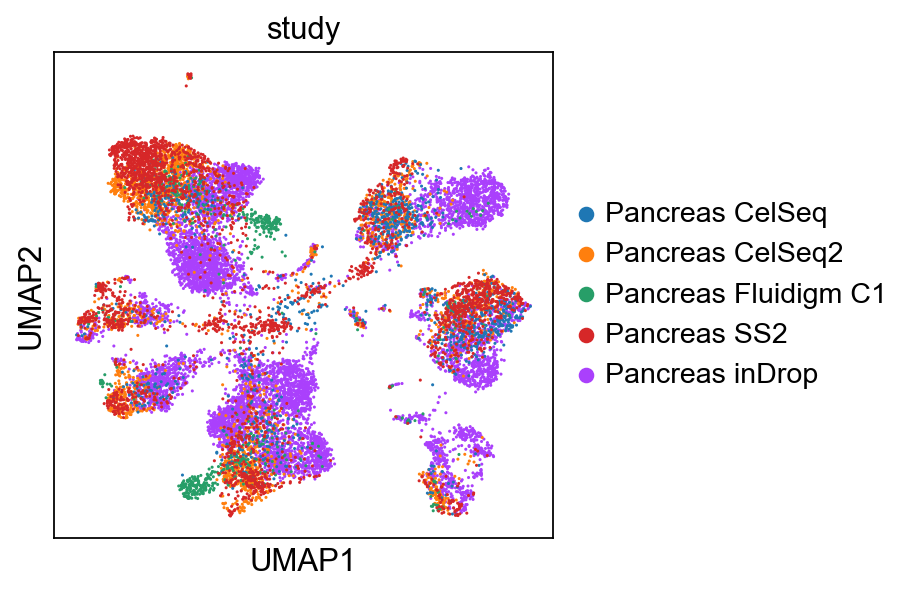

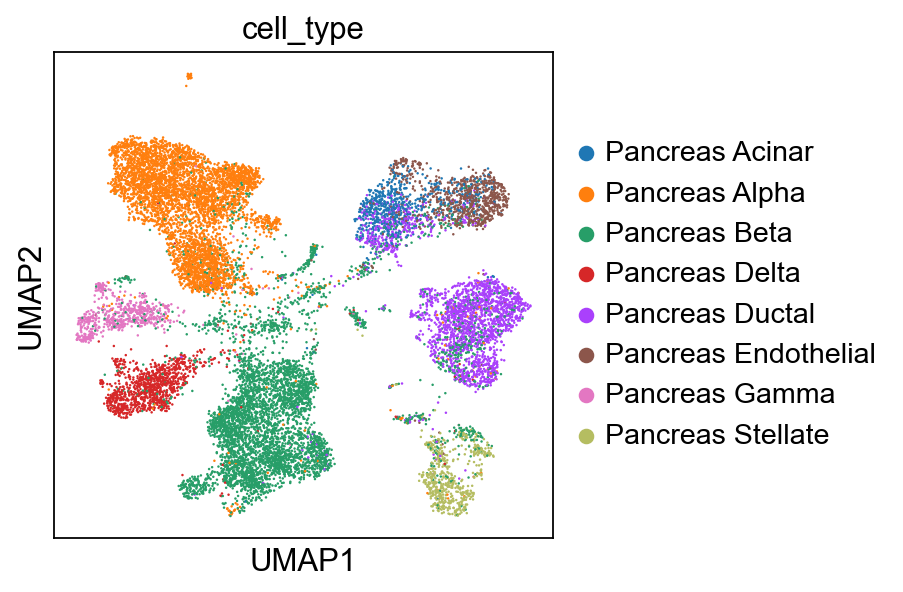

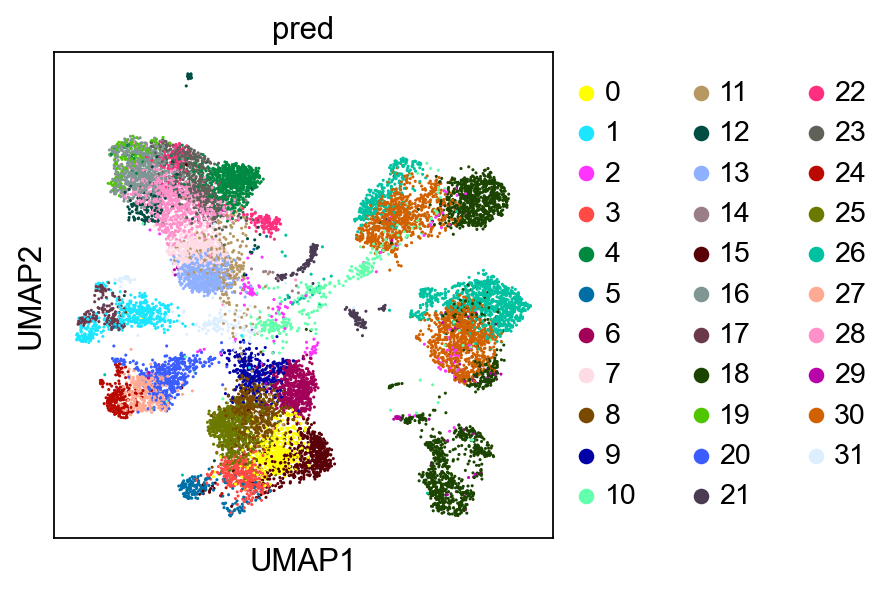

In [378]:
model1502c2.cpu()
model1502c2.eval()
#output = model1501c(data, cond1=conds)
output = model1502c2(data, cond1=conds, y=None)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#adata.obsm["w"] = output["w"].detach().numpy()
del output
sc.pp.neighbors(adata, use_rep="z",)
sc.tl.umap(adata,)
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)
sc.pl.umap(adata, color=['pred'], wspace=0.35 )


In [380]:
reload (M15)
reload (Train)
model1502c3 = M15.VAE_Dirichlet_GMM_Type1502C(
    nx=adata.n_vars,
    nh=1024*2,
    nhp=1024*2,
    nhq=1024*2,
    nz=64,
    nw=32,
    numhidden=3,
    numhiddenp=3,
    numhiddenq=3,
    dropout=0.25,
    use_resnet=False,
    nclasses=labels.shape[1],
    nc1 = 5,
    yscale=1e0,
    dscale=1e0,
    mi_scale=1e0,
    cc_scale=1e1,
    temperature=0.15,
    do_cc=False,
    softargmax=False,
    eps=1e-6,
    concentration=1e0,
    #reclosstype="mse",
    #learned_prior = True,
    activation=nn.LeakyReLU(),
        )
model1502c3.apply(init_weights)
Train.trainSemiSuperLoopCond(
    model1502c3,
    labeled_data_loader,
    unlabeled_data_loader,
    labeled_data_loader,
    num_epochs=80,
    lrs = [1e-5, 1e-4, 1e-3,1e-3,1e-4,1e-5],
    device="cuda",
    wt=0,
    do_unlabeled=True,
    do_validation=False,
    report_interval=65,
    do_plot=False,
    test_accuracy=True,
)


True
True
epoch 0
labeled phase
rec: 4140.7412109375
loss_z: 121.45885467529297
loss_w: 181.38949584960938
loss_cluster: -0.3624454736709595
loss_d: 5.830588340759277
loss_y_alt: 3.76560378074646
loss_y_alt2: 2.8505117893218994
total_loss: 4456.03662109375
num_clusters: 6

[ 1.  1. -1. -1.  2.  2.  2.  2.] 
 0.19163690476190476 
 [ 0.37142857  0.5        -1.         -1.          0.8         0.32
  1.          0.54166667]
0.4444444444444444 

unlabeled phase
rec: 3956.618896484375
loss_z: 97.0298080444336
loss_w: 24.658756256103516
loss_cluster: -0.34126490354537964
loss_d: 4.375143527984619
loss_y_alt: 1.2246935367584229
loss_y_alt2: 0
total_loss: 4083.9072265625
num_clusters: 4

epoch 65
labeled phase
rec: 2104.713134765625
loss_z: 33.72522735595703
loss_w: 5.482351779937744
loss_cluster: -0.9064850807189941
loss_d: 1.7413309812545776
loss_y_alt: 2.058368444442749
loss_y_alt2: 0.802977442741394
total_loss: 2148.5234375
num_clusters: 8

[5. 1. 2. 3. 4. 5. 1. 7.] 
 0.7272727272727273 
 

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pred' as categorical


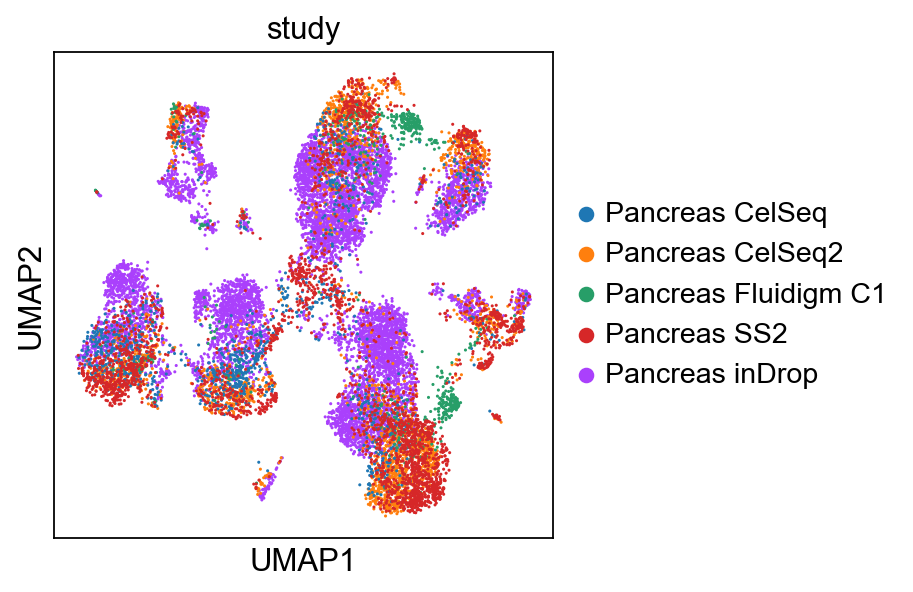

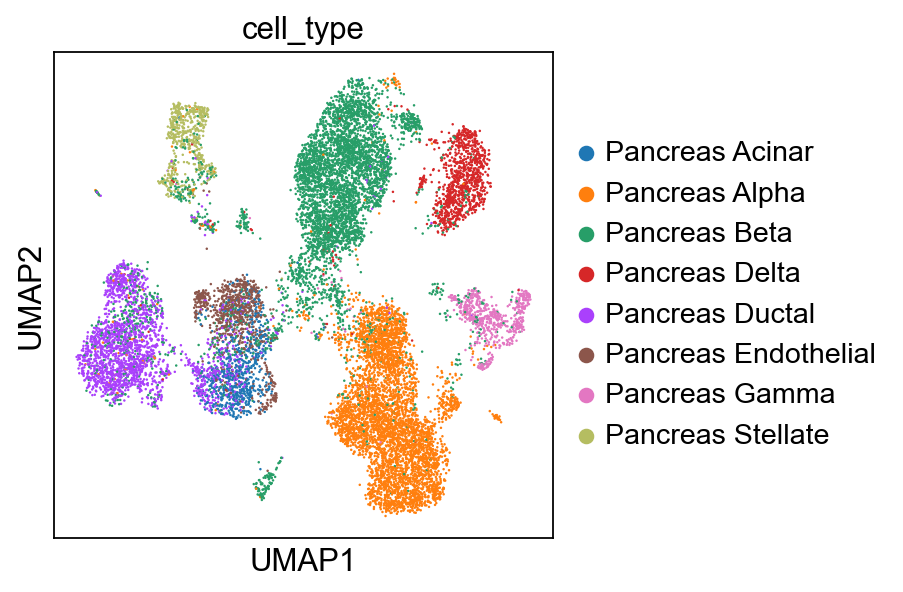

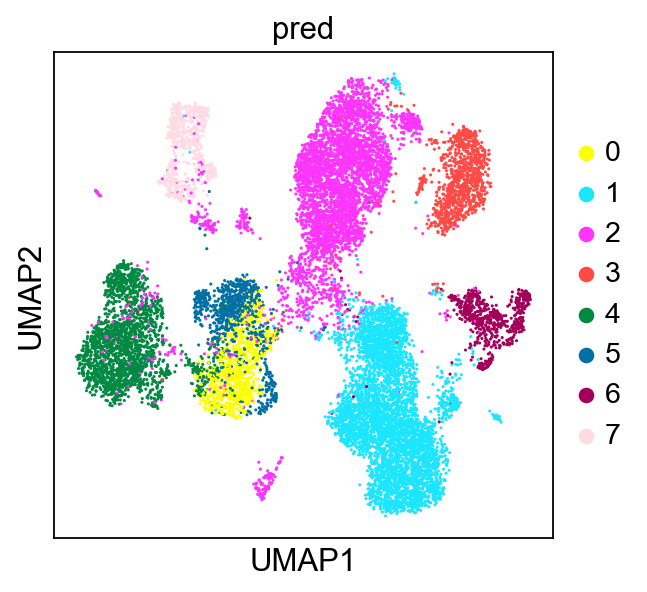

In [381]:
model1502c3.cpu()
model1502c3.eval()
#output = model1501c(data, cond1=conds)
output = model1502c3(data, cond1=conds, y=None)
adata.obsm["z"] = output["z"].detach().numpy()
adata.obs["pred"] = output["q_y"].detach().argmax(-1).numpy().astype(str)
#adata.obsm["w"] = output["w"].detach().numpy()
del output
sc.pp.neighbors(adata, use_rep="z",)
sc.tl.umap(adata,)
sc.pl.umap(adata, color=['study', ], wspace=0.35)
sc.pl.umap(adata, color=['cell_type'], size=5, wspace=5)
sc.pl.umap(adata, color=['pred'], wspace=0.35 )


In [390]:
############### Trying to reduce reconstruction error
adata.X.mean()
adata.X.max()
adata.X.sum(-1).mean()

904.0452

In [404]:
bdata = sc.read("./data/pancreas.h5ad")
bdata.X = bdata.raw.X
sc.pp.filter_cells(bdata, min_genes=50)
sc.pp.filter_genes(bdata, min_cells=3)
sc.pp.normalize_per_cell(bdata, 1e4)
sc.pp.log1p(bdata)
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)

filtered out 158 cells that have less than 50 genes expressed
filtered out 5 genes that are detected in less than 3 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [442]:
bdata.X.sum(-1)
bdata.var["highly_variable"].sum()
adata.X.mean(),  adata.X.max(), adata.X.sum(-1).mean() , (adata.X**2).sum(-1).mean()
bdata.X.mean(),  bdata.X.max(), bdata.X.sum(-1).mean() , (bdata.X**2).sum(-1).mean()

(0.45947313, 9.1873865, 457.17575, 1643.5521)

In [432]:
enc_ct = LabelEncoder()
enc_ct2 = LabelEncoder()
datab = torch.FloatTensor(bdata.X)
enc_ct.fit(bdata.obs["cell_type"])
enc_ct2.fit(bdata.obs["study"])
blabels = torch.IntTensor(
        enc_ct.transform(bdata.obs["cell_type"]))
blabels = F.one_hot(blabels.long(), num_classes=enc_ct.classes_.size).float()
bconds = torch.IntTensor(
        enc_ct2.transform(bdata.obs["study"]))
bconds = F.one_hot(bconds.long(), num_classes=enc_ct2.classes_.size).float()
subset = ut.randomSubset(s=len(blabels), r=0.11)
bdata_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSetV2(dati=[datab, blabels, bconds]),
        batch_size=128,
        shuffle=True,
        )


blabeled_data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSetV2(
            dati=[datab[subset], blabels[subset], bconds[subset]]),
        batch_size=128,
        shuffle=True,
        )
bunlabeled_data_loader = torch.utils.data.DataLoader(
        dataset=ut.SynteticDataSetV2(
            dati=[datab[subset == False], blabels[subset == False], bconds[subset == False]]),
        batch_size=128,
        shuffle=True,
        )

In [433]:
bconds.shape

torch.Size([15523, 5])

In [444]:
model1500b = M15.AE_Type1500(
    nx = bdata.n_vars,
    nh=1024,nhq=1024,nhp=1024,
    nz=64,
    zscale=1,
    numhidden=2,
    numhiddenq=2,
    numhiddenp=2,
    use_resnet=False,
    bn=True,
    #reclosstype="mse",
    activation=nn.LeakyReLU(),
)
model1500b.apply(init_weights)
Train.basicTrainLoop(
        model=model1500b,
        train_loader=bdata_loader,
        test_loader=None,
        num_epochs=31,
        lrs=[1e-3, 1e-3, 1e-4, 1e-5],
        wt=0,
        report_interval=35,
        )



epoch's lr =  0.001
epoch 0
training phase
rec: 1987.53271484375
total_loss: 1987.53271484375

epoch's lr =  0.001
epoch 0
training phase
rec: 599.6343994140625
total_loss: 599.6343994140625

epoch's lr =  0.0001
epoch 0
training phase
rec: 508.32183837890625
total_loss: 508.32183837890625

epoch's lr =  1e-05
epoch 0
training phase
rec: 582.4561767578125
total_loss: 582.4561767578125

done training
